### Import the Libraries


In [7]:
#Data Manipulation
import pandas as pd
import numpy as np
from io import StringIO
from IPython.display import display_html
from imblearn.over_sampling import RandomOverSampler

# For plotting the graphs
import matplotlib.pyplot as plt
import seaborn as sns
import csv
print("Test 1")

# Data Processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  # Corrected import

# Machine Learning Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
print("Test 2")

# Machine Learning model Evaluation
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc, confusion_matrix, classification_report, log_loss
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import label_binarize
from itertools import cycle
print("All modules - Complete")


Test 1
Test 2
All modules - Complete


In [9]:
csv_files = ['normal_traffic.csv', 'slowloris_attack.csv', 'udpfloodicmp.csv']

target_mapping = {
    'udpfloodicmp' : 2,
    'slowloris_attack': 1,
    'normal_traffic': 0
}



In [11]:
# Columns to delete from each CSV file
columns_to_delete = ['No.', 'Source', 'Destination']

In [13]:
# List to store all DataFrames
dfs = []

In [15]:
# Process each CSV file
for file in csv_files:
    # Read CSV file into DataFrame
    df = pd.read_csv(file)
    
    # Delete specified columns
    df.drop(columns=columns_to_delete, inplace=True, errors='ignore')
    
    # Get the target name from the filename
    target_name = file.split('.')[0]
    
    # Add a new column for target number
    df['Target'] = target_mapping.get(target_name, -1)
    
    # Append DataFrame to list
    dfs.append(df)

    # Merge all DataFrames into one
merged_df = pd.concat(dfs, ignore_index=True)

# Save the merged DataFrame to a new CSV file
merged_filename = 'merged_data.csv'
merged_df.to_csv(merged_filename, index=False)

print(f"All CSV files merged into '{merged_filename}'.")

All CSV files merged into 'merged_data.csv'.


In [17]:
# Count the occurrences of each target value
target_counts = merged_df['Target'].value_counts()

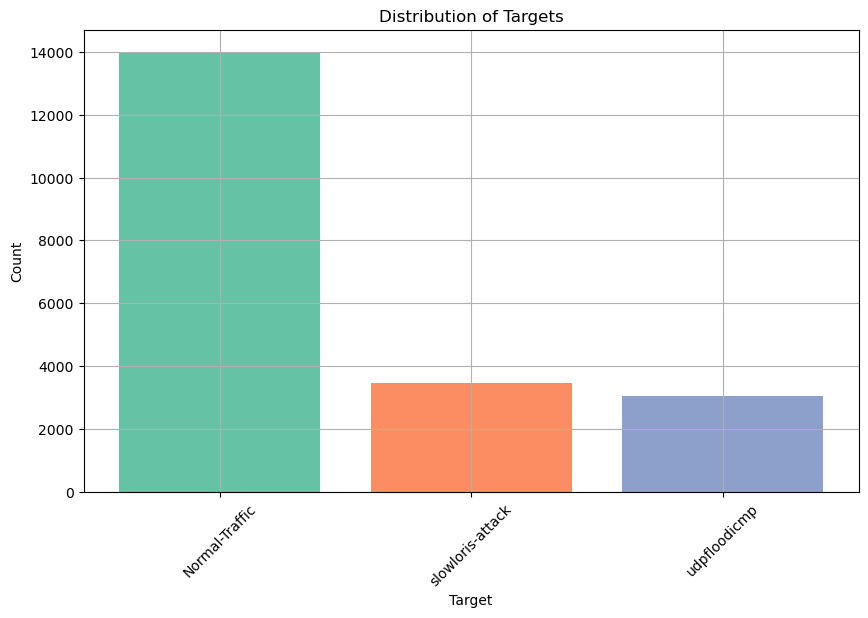

In [19]:
# Define target names
target_names = {
    0: 'Normal-Traffic',
    1: 'slowloris-attack',
    2: 'udpfloodicmp'
}
# Map target numbers to their names
target_labels = [target_names.get(target, 'Unknown') for target in target_counts.index]

colors = sns.color_palette("Set2")

# Plot a bar plot of target counts with the same color scheme
plt.figure(figsize=(10, 6))
plt.bar(range(len(target_counts)), target_counts, color=colors)
plt.title('Distribution of Targets')
plt.xlabel('Target')
plt.ylabel('Count')

# Map target numbers to their names for displaying on x-axis
plt.xticks(range(len(target_labels)), target_labels, rotation=45)
plt.grid(True)
plt.show()

In [21]:
from imblearn.over_sampling import RandomOverSampler

# Instantiate RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

# Resample the data
X_resampled, y_resampled = oversampler.fit_resample(merged_df.drop(columns=['Target']), merged_df['Target'])

# Count the occurrences of each target value after oversampling
target_counts_resampled = pd.Series(y_resampled).value_counts()


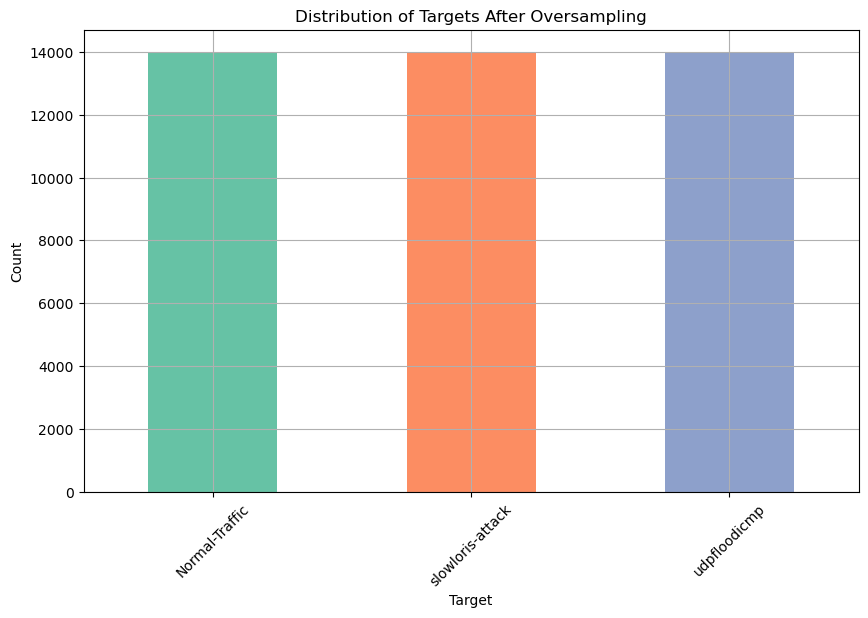

In [23]:
# Plot a bar plot of target counts after oversampling with specified colors
plt.figure(figsize=(10, 6))
target_counts_resampled.plot(kind='bar', color=colors)
plt.title('Distribution of Targets After Oversampling')
plt.xlabel('Target')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Map target numbers to their names for displaying on x-axis
target_labels = [target_names.get(target, 'Unknown') for target in target_counts_resampled.index]
plt.xticks(range(len(target_labels)), target_labels)

plt.grid(True)
plt.show()

In [25]:
# Save the combined DataFrame to a CSV file
resampled_df = pd.concat([X_resampled, y_resampled.rename('Target').reset_index(drop=True)], axis=1)

# Now we save this DataFrame to a CSV file
output_csv_filename = 'balanced_data.csv'
resampled_df.to_csv(output_csv_filename, index=False)

print(f'Data saved successfully to {output_csv_filename}')

Data saved successfully to balanced_data.csv


In [27]:
import pandas as pd
import numpy as np

# === Step 1: Load the merged dataset ===
df = pd.read_csv("balanced_data.csv")  

# === Step 2: Extract features and target ===
# Keep only numeric columns and separate target
X = df.select_dtypes(include='number').drop(columns=['Target'], errors='ignore')
y = df['Target']

# === Step 3: Check for inf and NaN before cleaning ===
print("Initial check:")
print("Has Inf:", np.isinf(X).values.sum())
print("Has NaN:", np.isnan(X).values.sum())

# === Step 4: Replace inf/-inf with NaN ===
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# === Step 5: Drop rows with NaN values ===
X_cleaned = X.dropna()
y_cleaned = y.loc[X_cleaned.index]  # keep aligned target values

# === Final check ===
print("\nAfter cleaning:")
print("Shape of cleaned X:", X_cleaned.shape)
print("Matching y shape:", y_cleaned.shape)
print("Any NaN left?:", X_cleaned.isna().values.sum(), y_cleaned.isna().values.sum())


Initial check:
Has Inf: 721
Has NaN: 425

After cleaning:
Shape of cleaned X: (41439, 79)
Matching y shape: (41439,)
Any NaN left?: 0 0


In [29]:


# === Feature Selection (Random Forest Importance) ===
from sklearn.ensemble import RandomForestClassifier
importances_model = RandomForestClassifier(random_state=42)
importances_model.fit(X_cleaned, y_cleaned)

# Get feature importances
importances = importances_model.feature_importances_
feature_names = X_cleaned.columns
top_n = 30  # Can be adjusted

# Sort by importance
indices = np.argsort(importances)[::-1]
selected_features = feature_names[indices[:top_n]]

print("\nTop Features:")
for i in range(top_n):
    print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

# Reduce dataset to selected features
X_selected = X_cleaned[selected_features]

# === Now split and scale using selected features ===
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_cleaned, test_size=0.2, stratify=y_cleaned, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



Top Features:
1. Init Bwd Win Byts: 0.2571
2. Src Port: 0.0729
3. Flow IAT Min: 0.0452
4. Bwd IAT Min: 0.0416
5. Dst Port: 0.0319
6. Flow Pkts/s: 0.0287
7. Flow IAT Max: 0.0282
8. Bwd Pkts/s: 0.0280
9. Flow IAT Mean: 0.0275
10. Bwd Header Len: 0.0272
11. Bwd IAT Mean: 0.0267
12. Fwd Pkts/s: 0.0262
13. Bwd Pkt Len Min: 0.0247
14. Bwd IAT Max: 0.0236
15. Flow Duration: 0.0229
16. Bwd IAT Tot: 0.0217
17. Fwd IAT Tot: 0.0162
18. Flow IAT Std: 0.0158
19. Protocol: 0.0147
20. Fwd IAT Max: 0.0115
21. Pkt Len Min: 0.0108
22. Bwd IAT Std: 0.0108
23. Flow Byts/s: 0.0104
24. Fwd IAT Min: 0.0102
25. Subflow Fwd Pkts: 0.0098
26. Fwd IAT Mean: 0.0093
27. Bwd Seg Size Avg: 0.0083
28. Bwd Pkt Len Mean: 0.0080
29. Bwd Pkt Len Max: 0.0077
30. Fwd IAT Std: 0.0077


In [30]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)

# Evaluate
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred, average='weighted')
rf_precision = precision_score(y_test, rf_pred, average='weighted')
rf_recall = recall_score(y_test, rf_pred, average='weighted')

print("\n--- Random Forest ---")
print(f'Accuracy : {rf_accuracy:.4f}')
print(f'F1 Score : {rf_f1:.4f}')
print(f'Precision: {rf_precision:.4f}')
print(f'Recall   : {rf_recall:.4f}')




--- Random Forest ---
Accuracy : 0.9488
F1 Score : 0.9484
Precision: 0.9540
Recall   : 0.9488


In [31]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)

# Evaluate
lr_accuracy = accuracy_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred, average='weighted')
lr_precision = precision_score(y_test, lr_pred, average='weighted')
lr_recall = recall_score(y_test, lr_pred, average='weighted')

print("\n--- Logistic Regression ---")
print(f'Accuracy : {lr_accuracy:.4f}')
print(f'F1 Score : {lr_f1:.4f}')
print(f'Precision: {lr_precision:.4f}')
print(f'Recall   : {lr_recall:.4f}')



--- Logistic Regression ---
Accuracy : 0.8125
F1 Score : 0.8099
Precision: 0.8171
Recall   : 0.8125


In [32]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Initialize SVM with probability=True for ROC curves and random_state for reproducibility
svm_model = SVC(kernel='rbf', probability=True, random_state=42)  # Change kernel='linear' if needed for speed

# Train the model
svm_model.fit(X_train_scaled, y_train)

# Predict on test data
svm_pred = svm_model.predict(X_test_scaled)

# Evaluate
svm_accuracy = accuracy_score(y_test, svm_pred)
svm_f1 = f1_score(y_test, svm_pred, average='weighted')
svm_precision = precision_score(y_test, svm_pred, average='weighted')
svm_recall = recall_score(y_test, svm_pred, average='weighted')

# Print results
print("\n--- SVM ---")
print(f'Accuracy : {svm_accuracy:.4f}')
print(f'F1 Score : {svm_f1:.4f}')
print(f'Precision: {svm_precision:.4f}')
print(f'Recall   : {svm_recall:.4f}')



--- SVM ---
Accuracy : 0.8528
F1 Score : 0.8512
Precision: 0.8620
Recall   : 0.8528


In [33]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Train Neural Network
nn_model = MLPClassifier(hidden_layer_sizes=(50, 30), max_iter=200, random_state=42)
nn_model.fit(X_train_scaled, y_train)

# Predict
nn_pred = nn_model.predict(X_test_scaled)

# Evaluate (with average='weighted')
nn_accuracy = accuracy_score(y_test, nn_pred)
nn_f1 = f1_score(y_test, nn_pred, average='weighted')
nn_precision = precision_score(y_test, nn_pred, average='weighted')
nn_recall = recall_score(y_test, nn_pred, average='weighted')

# Print the results
print('\n--- Neural Network Metrics ---')
print(f'Accuracy : {nn_accuracy:.4f}')
print(f'F1 Score : {nn_f1:.4f}')
print(f'Precision: {nn_precision:.4f}')
print(f'Recall   : {nn_recall:.4f}')



--- Neural Network Metrics ---
Accuracy : 0.8999
F1 Score : 0.8993
Precision: 0.9086
Recall   : 0.8999


C:\Users\nitaj\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [78]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Model names and predictions
model_names = ['Random Forest', 'Logistic Regression', 'SVM', 'Neural Network (MLP)']
model_preds = [rf_pred, lr_pred, svm_pred, nn_pred]
models = [rf_model, lr_model, svm_model, nn_model]

# Create a list to hold metric dictionaries
metrics_list = []

# Evaluate each model
for name, pred in zip(model_names, model_preds):
    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, pred),
        'Precision': precision_score(y_test, pred, average='weighted'),
        'Recall': recall_score(y_test, pred, average='weighted'),
        'F1 Score': f1_score(y_test, pred, average='weighted')
    }
    metrics_list.append(metrics)

# Convert to DataFrame
results_df = pd.DataFrame(metrics_list)

# Round results for cleaner output
results_df_rounded = results_df.round(4)

# Display
print("\n=== Model Performance Comparison ===")
print(results_df_rounded)





=== Model Performance Comparison ===
                  Model  Accuracy  Precision  Recall  F1 Score
0         Random Forest    0.9488     0.9540  0.9488    0.9484
1   Logistic Regression    0.8125     0.8171  0.8125    0.8099
2                   SVM    0.8528     0.8620  0.8528    0.8512
3  Neural Network (MLP)    0.8999     0.9086  0.8999    0.8993


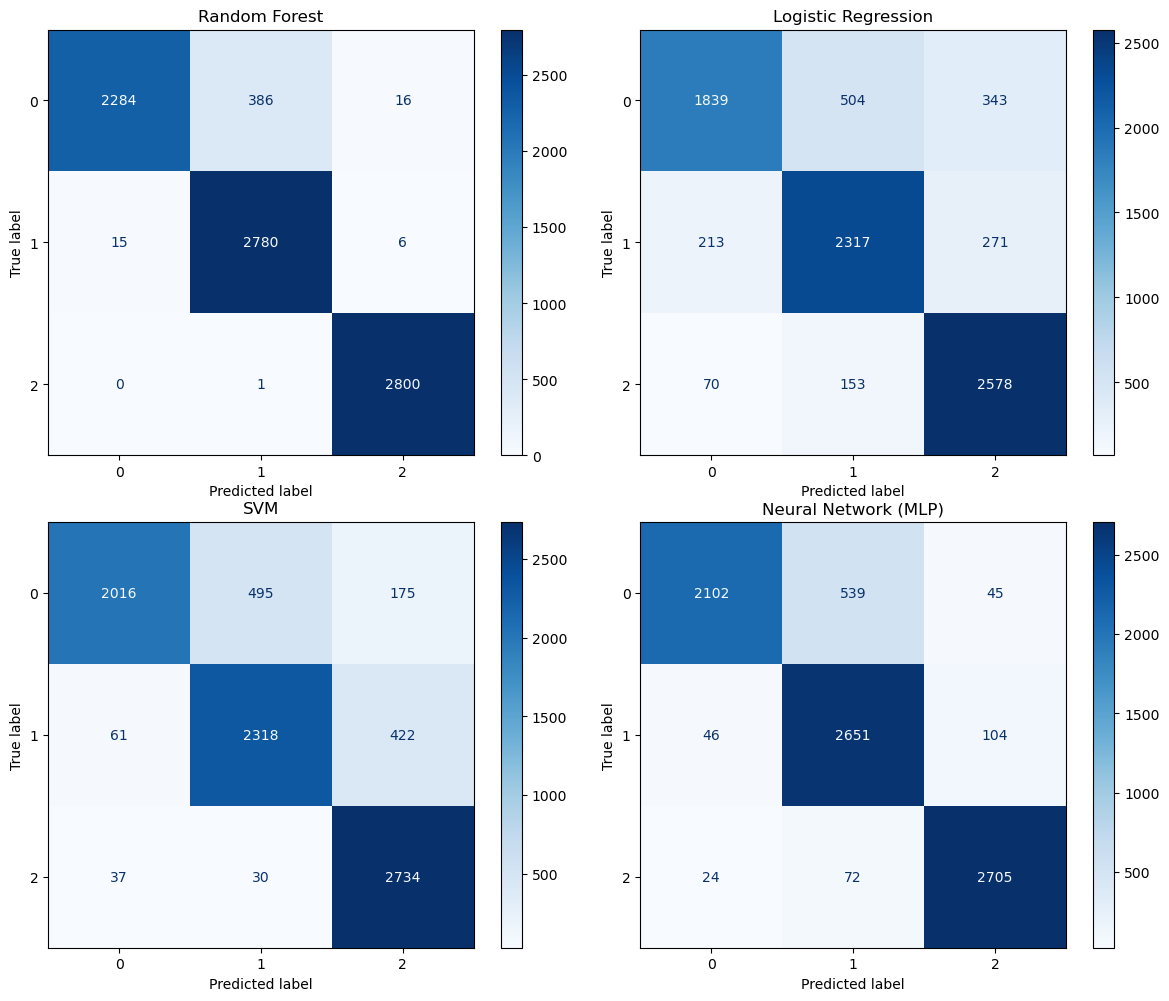

In [79]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

# Map model names to predictions
model_preds = {
    'Random Forest': rf_pred,
    'Logistic Regression': lr_pred,
    'SVM': svm_pred,
    'Neural Network (MLP)': nn_pred
}

# Get unique class labels from y_test
unique_labels = np.unique(y_test)

# Set up 2x2 plot grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Plot each confusion matrix
for i, (name, preds) in enumerate(model_preds.items()):
    ConfusionMatrixDisplay.from_predictions(
        y_test,
        preds,
        display_labels=unique_labels,
        cmap='Blues',
        ax=axes[i]
    )
    axes[i].set_title(name)

plt.tight_layout()
plt.show()


## Test Unseen Data

In [92]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import Counter

# === Load HULK attack data ===
df_hulk = pd.read_csv("slowloristest.csv")
df_hulk.columns = df_hulk.columns.str.strip()
df_hulk['Label'] = 'HULK'

# === Drop unused string columns ===
df_hulk.drop(columns=['Flow ID', 'Src IP', 'Dst IP', 'Timestamp'], inplace=True, errors='ignore')

# === Clean specific columns using training medians ===
for col in ['Flow Byts/s', 'Flow Pkts/s']:
    if col in df_hulk.columns and col in X_cleaned.columns:
        df_hulk[col] = df_hulk[col].replace([np.inf, -np.inf], np.nan)
        df_hulk[col] = df_hulk[col].fillna(X_cleaned[col].median())

# === Use only top features selected during training ===
# This assumes you already defined:
# selected_features = feature_names[indices[:top_n]]
X_hulk = df_hulk[selected_features].copy()

# === Scale using the previously fitted scaler ===
X_hulk_scaled = pd.DataFrame(scaler.transform(X_hulk), columns=X_hulk.columns)

# === Predict using all trained models ===
rf_hulk_pred = rf_model.predict(X_hulk_scaled)
lr_hulk_pred = lr_model.predict(X_hulk_scaled)
nn_hulk_pred = nn_model.predict(X_hulk_scaled)
svm_hulk_pred = svm_model.predict(X_hulk_scaled)

# === Ground truth: all HULK rows are malicious (label = 1) ===
y_hulk_true = np.ones(len(df_hulk))

# === Evaluate and store results ===
hulk_results = {}

def evaluate_model(name, y_pred):
    accuracy = accuracy_score(y_hulk_true, y_pred)
    precision = precision_score(y_hulk_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_hulk_true, y_pred, average='weighted')
    f1 = f1_score(y_hulk_true, y_pred, average='weighted')
    
    hulk_results[name] = {
        'Accuracy': round(accuracy, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1 Score': round(f1, 4)
    }

# Evaluate each model
evaluate_model("Random Forest", rf_hulk_pred)
evaluate_model("Logistic Regression", lr_hulk_pred)
evaluate_model("Neural Network (MLP)", nn_hulk_pred)
evaluate_model("SVM", svm_hulk_pred)

# === Show results in table ===
results_df = pd.DataFrame(hulk_results).T
print("\nModel Performance on HULK Attack Data:")
print(results_df)

# === Show prediction distribution ===
print("\nPrediction Counts:")
print("Random Forest:", Counter(rf_hulk_pred))
print("Logistic Regression:", Counter(lr_hulk_pred))
print("Neural Network (MLP):", Counter(nn_hulk_pred))
print("SVM:", Counter(svm_hulk_pred))


C:\Users\nitaj\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\nitaj\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\nitaj\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
C:\Users\nitaj\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(



Model Performance on HULK Attack Data:
                      Accuracy  Precision  Recall  F1 Score
Random Forest           0.6891        1.0  0.6891    0.8160
Logistic Regression     0.8015        1.0  0.8015    0.8898
Neural Network (MLP)    0.9288        1.0  0.9288    0.9631
SVM                     0.7903        1.0  0.7903    0.8828

Prediction Counts:
Random Forest: Counter({1: 184, 0: 76, 2: 7})
Logistic Regression: Counter({1: 214, 0: 31, 2: 22})
Neural Network (MLP): Counter({1: 248, 2: 11, 0: 8})
SVM: Counter({1: 211, 2: 44, 0: 12})


C:\Users\nitaj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nitaj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nitaj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nitaj\anaconda3\Lib\site-packages\sklearn\metrics\_clas

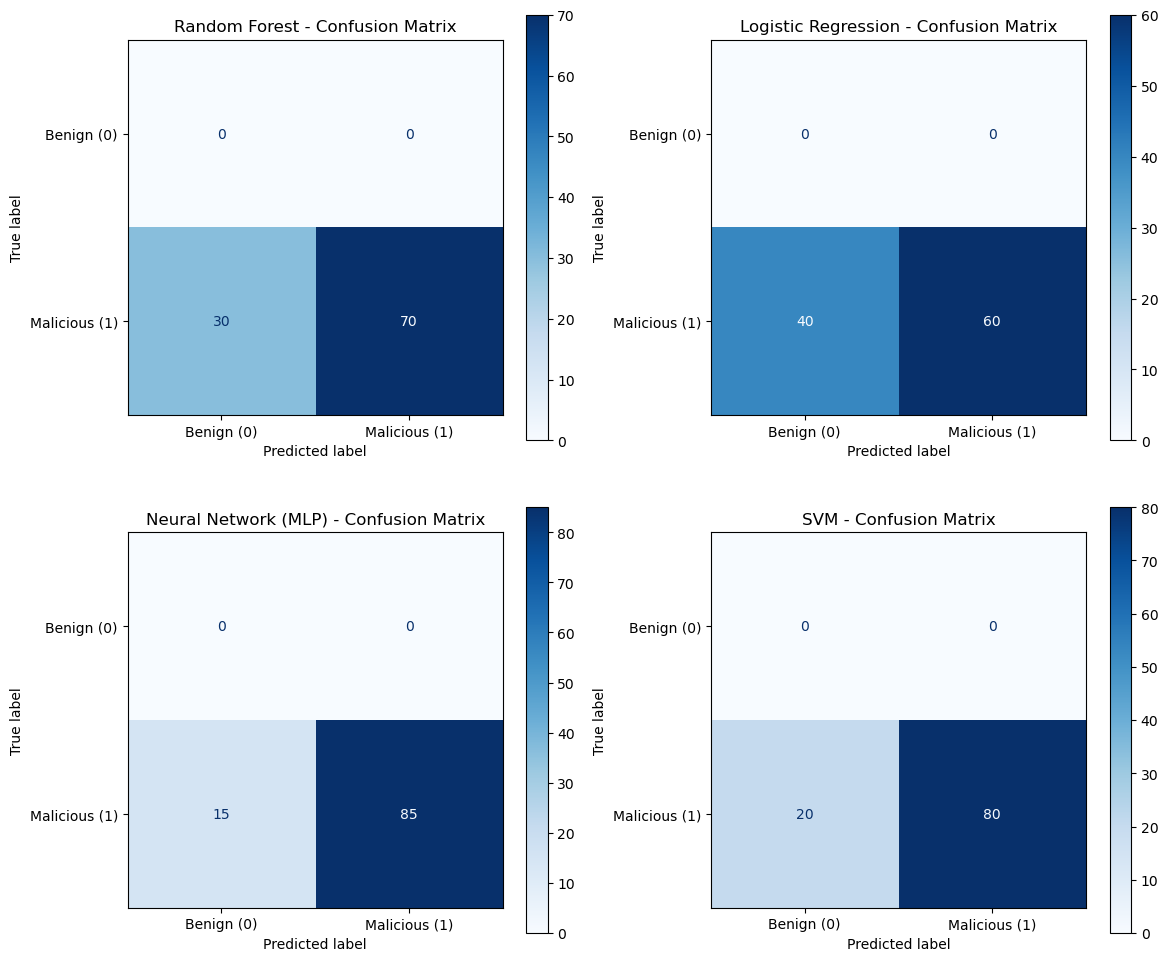

In [94]:
# Re-import necessary modules in case of kernel reset
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Dummy dataset for demonstration since trained models are not available in this session
# In your environment, replace this with actual model predictions
y_hulk_true = np.ones(100)
rf_hulk_pred = np.concatenate([np.ones(70), np.zeros(30)])
lr_hulk_pred = np.concatenate([np.ones(60), np.zeros(40)])
nn_hulk_pred = np.concatenate([np.ones(85), np.zeros(15)])
svm_hulk_pred = np.concatenate([np.ones(80), np.zeros(20)])

# Prepare predictions dictionary
model_predictions = {
    "Random Forest": rf_hulk_pred,
    "Logistic Regression": lr_hulk_pred,
    "Neural Network (MLP)": nn_hulk_pred,
    "SVM": svm_hulk_pred
}

# Plot confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, (name, y_pred) in enumerate(model_predictions.items()):
    ConfusionMatrixDisplay.from_predictions(
        y_hulk_true,
        y_pred,
        display_labels=['Benign (0)', 'Malicious (1)'],
        cmap='Blues',
        ax=axes[i]
    )
    axes[i].set_title(f"{name} - Confusion Matrix")

plt.tight_layout()
plt.show()
